#Imports


In [ ]:
import pandas as pd

from collections import Counter, defaultdict

import re

import random

import string

import numpy as np

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

import nltk
nltk.download('punkt_tab')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sentence_transformers import SentenceTransformer

!pip install keybert
from keybert import KeyBERT

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.6 MB/s eta 0:00:00


#Data Collection/Cleaning

In [ ]:
url = "https://raw.githubusercontent.com/tinh0/recipe-sentiment-analysis/main/reviews.csv"
df = pd.read_csv(url)
#print(df.head(5))

In [ ]:
# Fixed cleaning text a little
def clean_text(t):
  t = re.sub(r'<[^>]+>', ' ', t)
  t = t.lower()
  t = re.sub(r'[^a-z\s]', ' ', t)
  return t

df['clean_review'] = df['review_text'].apply(clean_text)

In [ ]:
df.columns

Index(['id', 'docId', 'displayName', 'starRating', 'helpfulCount', 'madeIt',
       'created_iso', 'profileUrl', 'review_text', 'clean_review'],
      dtype='object')

distribution of ratings

In [ ]:
rating_counts = df['starRating'].value_counts().sort_index().reset_index()
rating_counts.columns = ['starRating', 'count']

print(rating_counts)

# # Histogram Plot
# counts, bins, patches = plt.hist(
#     df['starRating'],
#     bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
#     edgecolor='black'
# )
# # Add labels above bars
# for count, x in zip(counts, bins[:-1]):
#     plt.text(x + 0.5, count + 0.1, int(count), ha='center', va='bottom')

# plt.xticks([1, 2, 3, 4, 5])
# plt.grid(False)
# plt.title("Distribution of Star Ratings")
# plt.xlabel("Rating")
# plt.ylabel("Frequency")
# plt.show()

   starRating  count
0           1     92
1           2    109
2           3    316
3           4   1160
4           5   4481


In [ ]:
def count_words_in_group(texts):
    texts = [t for t in texts if t.strip()]  # remove empty strings
    if not texts:
        return Counter()
    return Counter(word.lower() for text in texts for word in text.split())

word_counts_by_recipe = df.groupby('docId')['clean_review'].apply(count_words_in_group)

#K-grams

In [ ]:
def get_k_grams_ratings(k, min_occurrences):
  counts = Counter()
  rating_sum = defaultdict(float)
  for text, rating in zip(df['clean_review'], df['starRating']):
      toks = [t for t in word_tokenize(text.lower()) if t.isalnum()]
      grams = list(ngrams(toks, k))
      if not grams:
            continue

      for g in grams:
            counts[g] += 1
            rating_sum[g] += float(rating)

  rows = []
  for g, c in counts.items():
  # must have at least n occurrences
      if c > min_occurrences:
          rows.append((' '.join(g), c, rating_sum[g] / c))

  return rows[:]

In [ ]:
three_word_gram = get_k_grams_ratings(k=3, min_occurrences=0)
three_word_gram.sort(key=lambda x: x[2])  # sorts by ratings
len(three_word_gram)

149860

In [ ]:
doc_to_kset = {}

def get_k_grams(k, min_occurrences):
  counts = Counter()
  for text, docId in zip(df['clean_review'], df['docId']):
      toks = [t for t in word_tokenize(text.lower()) if t.isalnum()]
      grams = list(ngrams(toks, k))
      if docId not in doc_to_kset:
            doc_to_kset[docId] = []
      if not grams:
            continue
      for g in grams:
            counts[g] += 1
            if g not in doc_to_kset[docId]:
              doc_to_kset[docId].append(g)
  rows = []
  for g, c in counts.items():
  # must have at least n occurrences
      if c > min_occurrences:
          rows.append(g)
  return rows[:]


In [ ]:
kgrams = get_k_grams(k=3, min_occurrences=0)
# print(kgrams)
# print(doc_to_kset)
# print(docs)

vectorizer = CountVectorizer(
    analyzer='word',
    ngram_range=(3, 3),
    max_features=5000,
    min_df=5,
    max_df=0.8,
)

feature_matrix = vectorizer.fit_transform(df['clean_review'])

# TF-IDF & KeyBert

In [ ]:
tfidf_3gram = TfidfVectorizer(
    analyzer='word',
    ngram_range=(3, 3),   # Only trigrams
    max_features=5000,    # Optional: cap vocabulary size
    min_df=3,             # Ignore rare phrases
    max_df=0.8            # Ignore very common ones
)

tfidf_result = tfidf_3gram.fit_transform(df['clean_review'])
# print('\nidf values:')
# for ele1, ele2 in zip(tfidf_result.get_feature_names_out(), tfidf_result.idf_):
#     print(ele1, ':', ele2)

# print('\nWord indexes:')
# print(tfidf_result.vocabulary_)
# print('\ntf-idf value:')
print(tfidf_result)
# print('\ntf-idf values in matrix form:')
# print(tfidf_result.toarray())

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 48072 stored elements and shape (6158, 5000)>
  Coords	Values
  (0, 4196)	0.2861432565215155
  (0, 4310)	0.3408114708908524
  (0, 4765)	0.3776111181710436
  (0, 3598)	0.2827822431342401
  (0, 1444)	0.36391901102353896
  (0, 3393)	0.3776111181710436
  (0, 207)	0.19696640780574395
  (0, 2287)	0.1935284820476983
  (0, 1605)	0.19270644815775675
  (0, 1361)	0.1925437314895889
  (0, 1215)	0.1547670532138592
  (0, 4291)	0.2549271245686908
  (0, 1369)	0.2549271245686908
  (1, 2434)	0.6049746207901774
  (1, 1279)	0.5029242224930719
  (1, 2699)	0.6173110517636308
  (2, 1216)	0.30490115893745295
  (2, 4331)	0.4569471347054716
  (2, 1304)	0.4544391241743359
  (2, 2420)	0.5380652470904508
  (2, 1996)	0.4496726272036273
  (3, 1215)	0.3249767172732238
  (3, 3186)	0.8111210378160032
  (3, 201)	0.48628468538769454
  (4, 4177)	0.29902806927995895
  :	:
  (6156, 4521)	0.2559601631486296
  (6156, 1716)	0.20851260918249095
  (6156, 99)	0.2756657

In [ ]:
kw_model = KeyBERT()
keybert_vec = [
    kw_model.extract_keywords(
        doc,
        keyphrase_ngram_range=(3, 3),
        stop_words="english",
        use_mmr=True,
        diversity=0.6,
        top_n=10
    )
    for doc in df["clean_review"].tolist()
]

df["keyphrases"] = [[p for p, s in doc] for doc in keybert_vec]

mlb = MultiLabelBinarizer()
keybert_result = mlb.fit_transform(df["keyphrases"])
print(keybert_result)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
texts = df["clean_review"].astype(str).fillna("").tolist()

model = SentenceTransformer("all-MiniLM-L6-v2")
doc_emb = model.encode(
    texts,
    batch_size=64,
    convert_to_numpy=True,
    normalize_embeddings=True,
    show_progress_bar=True
)
print(doc_emb)

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

KeyboardInterrupt: 

# PCA

In [ ]:
SVD = TruncatedSVD(n_components=2, random_state=42)

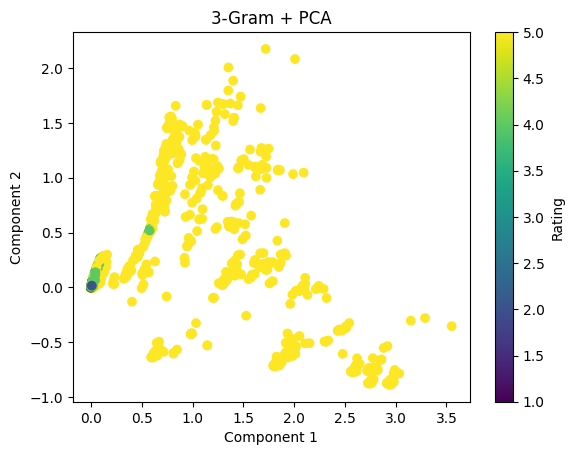

=== Example for rating 1 ★ ===
Index in df:  5569
PCA location: (x=0.006, y=0.013)
Text:  just wasted a    lbs of ground beef to make sloppy soup  if you are following this recipe  do not use   cups of water   

=== Example for rating 2 ★ ===
Index in df:  289
PCA location: (x=0.013, y=0.020)
Text:  this sounded so good  but the end result was not what i expected  way too much bread  i may try making it again using only one box of cornbread mix and either putting it on top or on the bottom  it t 

=== Example for rating 3 ★ ===
Index in df:  5237
PCA location: (x=0.011, y=0.026)
Text:  i decided to use this recipe when making my adult daughter a birthday cake   custard filling and chocolate icing were both very good although the cake itself was a disappointment and was very dry  i  

=== Example for rating 4 ★ ===
Index in df:  3662
PCA location: (x=0.019, y=0.035)
Text:  i made this on tbe fly and didn t have all the ingredients  i used garlic powder and ground ginger   then added soy

In [ ]:
feature_matrix_pca = SVD.fit_transform(feature_matrix)

# Plot for visualization
plt.scatter(feature_matrix_pca[:, 0], feature_matrix_pca[:, 1], c=df['starRating'], cmap='viridis')
plt.title("3-Gram + PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Rating")
plt.show()

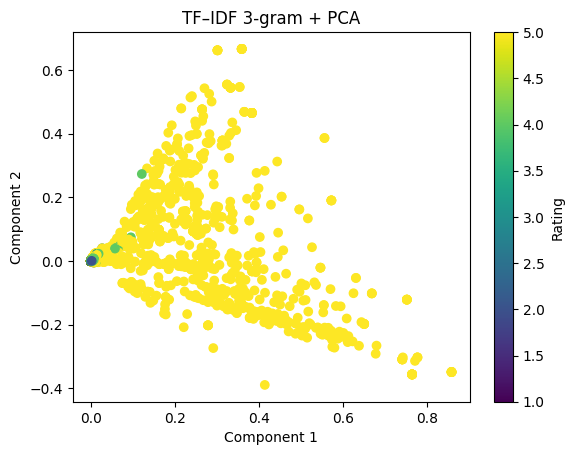


=== Examples for rating 1 ★ ===
- df index 5569, PCA (0.006, 0.013)
  words: if you are, cups of water, of ground beef, lbs of ground, ground beef to
- df index 78, PCA (0.008, 0.012)
  words: as the recipe, was bland and, the finished product, and sour cream, sour cream but
- df index 47, PCA (0.008, 0.014)
  words: as it cooked, followed the directions, did not work, amp did not, the directions exactly

=== Examples for rating 2 ★ ===
- df index 289, PCA (0.013, 0.020)
  words: it turned out, the end result, on the bottom, end result was, way too much
- df index 121, PCA (0.009, 0.019)
  words: this recipe exactly, with the exception, as written with, this one is, the exception of
- df index 793, PCA (0.012, 0.017)
  words: to make it

=== Examples for rating 3 ★ ===
- df index 5237, PCA (0.011, 0.026)
  words: to add little, add little more, on top of, use this recipe, to use this
- df index 4450, PCA (0.011, 0.027)
  words: in with the, recipe as written, with the meat, this recip

In [ ]:
result_tfidf_pca = SVD.fit_transform(tfidf_result)

# Plot for visualization
plt.scatter(result_tfidf_pca[:, 0], result_tfidf_pca[:, 1], c=df['starRating'], cmap='viridis')
plt.title("TF–IDF 3-gram + PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Rating")
plt.show()

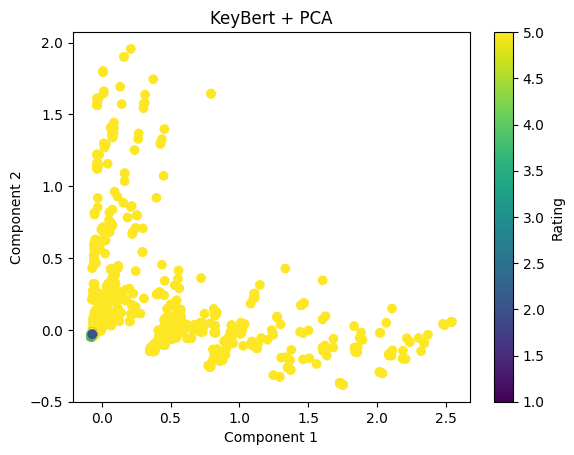


=== Examples for rating 1 ★ ===
- df index 25, PCA (-0.067, -0.030)
  words: found that the
- df index 3656, PCA (-0.067, -0.030)
  words: 
- df index 2054, PCA (-0.067, -0.030)
  words: took it out, longer than minutes, minutes to cook

=== Examples for rating 2 ★ ===
- df index 1846, PCA (-0.067, -0.030)
  words: the sauce was, it was easy, too sweet for, but the sauce, care for it
- df index 1453, PCA (-0.067, -0.030)
  words: like it was, felt like it, in my opinion
- df index 1544, PCA (-0.067, -0.030)
  words: had to add, to add some, and lemon juice

=== Examples for rating 3 ★ ===
- df index 4662, PCA (-0.067, -0.031)
  words: to make it, was way too, make it again
- df index 3593, PCA (-0.067, -0.031)
  words: it little more, was little dry, will make it, all the cheese, it was little
- df index 3523, PCA (-0.067, -0.031)
  words: was good but, it was good, back to the, this recipe for, made this recipe

=== Examples for rating 4 ★ ===
- df index 2008, PCA (-0.068, -0.031)
  

In [ ]:
pca_keybert = PCA(n_components=2, random_state=42)
keybert_pca = pca_keybert.fit_transform(keybert_result)

# Plot for visualization
plt.scatter(keybert_pca[:, 0], keybert_pca[:, 1], c=df['starRating'], cmap='viridis')
plt.title("KeyBert + PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Rating")
plt.show()

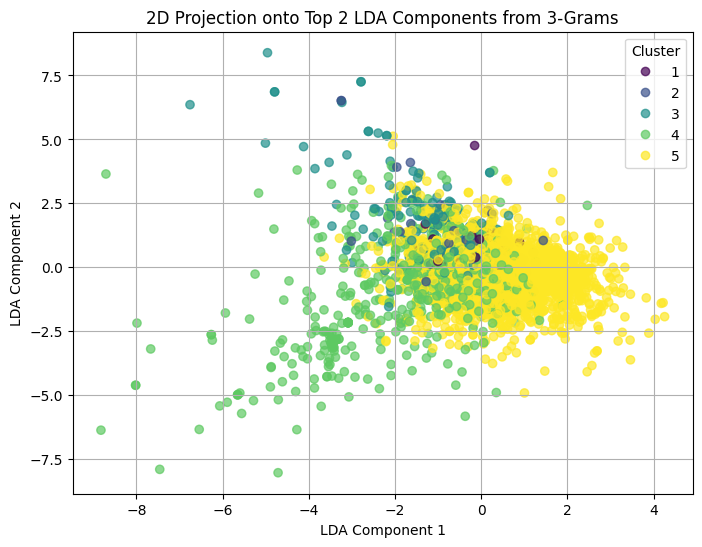


=== Examples for rating 1 ★ ===
- df index 1465, LDA (-0.126, 0.530)
  words: amp did not, did not work
- df index 53, LDA (-0.166, 0.686)
  words: amp did not, did not work, this recipe just, work for me, in the mix
- df index 3287, LDA (-0.111, 0.494)
  words: try this again, sweet potato casserole, canned sweet potatoes

=== Examples for rating 2 ★ ===
- df index 4535, LDA (-0.454, 0.882)
  words: way too much, amp confusing directions
- df index 143, LDA (-0.391, 0.784)
  words: this recipe but, the end result, it was the, think it was
- df index 1846, LDA (-0.302, 0.829)
  words: the sauce was, it was easy, too sweet for, but the sauce, care for it

=== Examples for rating 3 ★ ===
- df index 170, LDA (-0.792, 0.870)
  words: would have been, of fresh spinach
- df index 3542, LDA (-0.502, 1.120)
  words: it to be, found it to
- df index 4052, LDA (-0.818, 0.838)
  words: needs more seasoning, don think it, make again but, the second day, instead of just

=== Examples for rating 4 

In [ ]:
pca = PCA(n_components=200)
X_reduced = pca.fit_transform(feature_matrix)

y = df['starRating'].astype(int)

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_reduced, y)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('2D Projection onto Top 2 LDA Components from 3-Grams')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

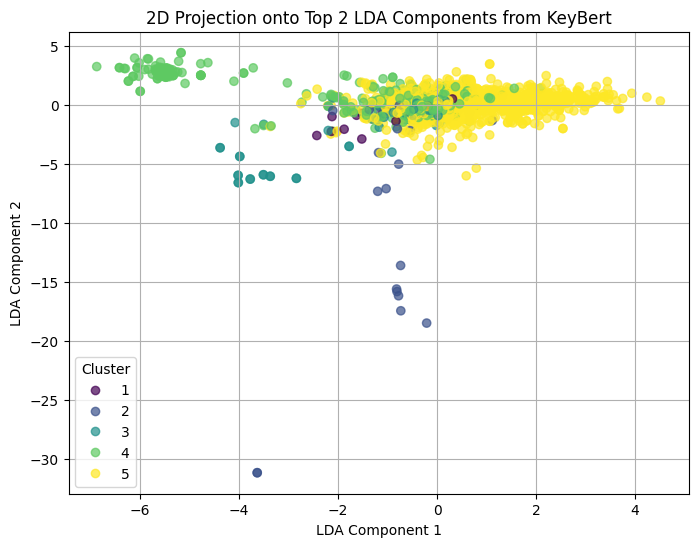


=== Examples for rating 1 ★ ===
- df index 5872, LDA (-0.358, -0.264)
  words: 
- df index 5891, LDA (-0.329, -0.164)
  words: 
- df index 3070, LDA (-0.298, -0.274)
  words: 

=== Examples for rating 2 ★ ===
- df index 3273, LDA (-0.542, -2.146)
  words: it tasted like, sweet potato casserole
- df index 5941, LDA (-0.803, -1.988)
  words: and ate it, beef first and, the beef first, make it again, my husband and
- df index 5765, LDA (-0.316, -0.653)
  words: salt pepper and, the rice and, in this dish, this recipe as, some of my

=== Examples for rating 3 ★ ===
- df index 5321, LDA (-0.452, -0.397)
  words: it turned out, had to do, be making this, had to add, making this again
- df index 2888, LDA (-0.499, -0.406)
  words: casserole dish and, my chicken breast, to eat it, not make again
- df index 5919, LDA (-0.415, -0.397)
  words: recipe it was, it might be, that it is, made this as, is that it

=== Examples for rating 4 ★ ===
- df index 3518, LDA (-0.692, 0.190)
  words: of cream 

In [ ]:
pca = PCA(n_components=200)
X_reduced = pca.fit_transform(keybert_result)

y = df['starRating'].astype(int)

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_reduced, y)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('2D Projection onto Top 2 LDA Components from KeyBert')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

feature_names = np.array(vectorizer.get_feature_names_out())
X_lda_coords = X_lda  # just a shorter name

ratings = sorted(np.unique(y))
examples_per_rating = 3
top_k_words = 5   # how many features to print per point

for rating in ratings:
    mask = (y == rating)
    idxs = np.where(mask)[0]

    xs = X_lda_coords[idxs, 0]
    ys = X_lda_coords[idxs, 1]

    # centroid for this rating in LDA space
    cx, cy = xs.mean(), ys.mean()

    # pick points closest to the centroid
    dists = (xs - cx) ** 2 + (ys - cy) ** 2
    order = np.argsort(dists)
    chosen = idxs[order[:examples_per_rating]]

    print(f"\n=== Examples for rating {rating} ★ ===")
    for j in chosen:
        row = feature_matrix[j]

        # convert row to dense 1D array
        if hasattr(row, "toarray"):
            row = row.toarray().ravel()
        else:
            row = np.asarray(row).ravel()

        # top-k features by weight for this doc
        top_idx = np.argsort(row)[::-1][:top_k_words]
        top_idx = [i for i in top_idx if row[i] > 0]
        words = feature_names[top_idx]

        xj, yj = X_lda_coords[j, 0], X_lda_coords[j, 1]
        print(f"- df index {j}, LDA ({xj:.3f}, {yj:.3f})")
        print("  words:", ", ".join(words))

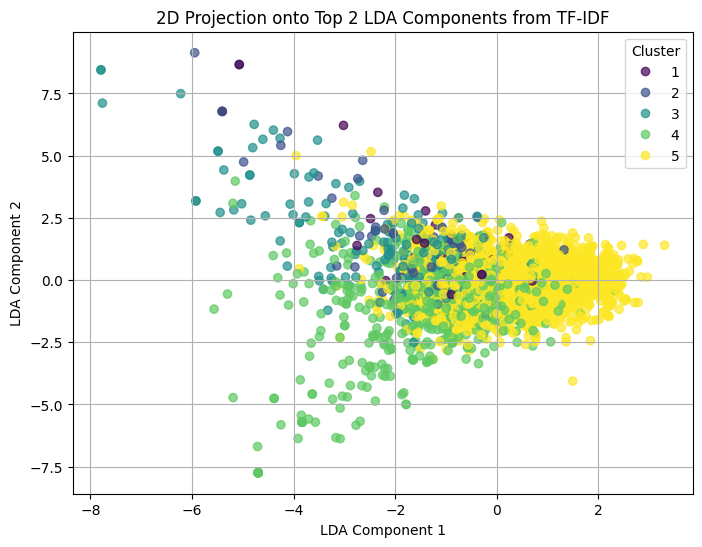


=== Examples for rating 1 ★ ===
- df index 3186, LDA (-0.725, 0.822)
  words: the crock pot, in the oven, in the crock, crock pot and, and it was
- df index 4341, LDA (-0.642, 0.899)
  words: me and my
- df index 5225, LDA (-0.678, 0.733)
  words: the cake was, cake was dry, boston cream pie, is the only, it was delicious

=== Examples for rating 2 ★ ===
- df index 1192, LDA (-0.962, 1.156)
  words: amp confusing directions
- df index 5323, LDA (-0.919, 1.075)
  words: this was just
- df index 793, LDA (-0.912, 1.270)
  words: to make it

=== Examples for rating 3 ★ ===
- df index 3480, LDA (-1.540, 0.784)
  words: was ok but, the dish was
- df index 4682, LDA (-1.293, 0.929)
  words: to thicken it, not much flavor
- df index 6110, LDA (-1.440, 1.104)
  words: was easy to, it was easy, this recipe again, of chili powder, chili powder and

=== Examples for rating 4 ★ ===
- df index 2731, LDA (-0.837, -0.581)
  words: followed the recipe, think next time, after the first, hours the chic

In [ ]:
pca = PCA(n_components=200)
X_reduced = pca.fit_transform(tfidf_result.toarray())

y = df['starRating'].astype(int)

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_reduced, y)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('2D Projection onto Top 2 LDA Components from TF-IDF')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

feature_names = np.array(vectorizer.get_feature_names_out())
X_lda_coords = X_lda  # just a shorter name

ratings = sorted(np.unique(y))
examples_per_rating = 3
top_k_words = 5   # how many features to print per point

for rating in ratings:
    mask = (y == rating)
    idxs = np.where(mask)[0]

    xs = X_lda_coords[idxs, 0]
    ys = X_lda_coords[idxs, 1]

    # centroid for this rating in LDA space
    cx, cy = xs.mean(), ys.mean()

    # pick points closest to the centroid
    dists = (xs - cx) ** 2 + (ys - cy) ** 2
    order = np.argsort(dists)
    chosen = idxs[order[:examples_per_rating]]

    print(f"\n=== Examples for rating {rating} ★ ===")
    for j in chosen:
        row = feature_matrix[j]

        # convert row to dense 1D array
        if hasattr(row, "toarray"):
            row = row.toarray().ravel()
        else:
            row = np.asarray(row).ravel()

        # top-k features by weight for this doc
        top_idx = np.argsort(row)[::-1][:top_k_words]
        top_idx = [i for i in top_idx if row[i] > 0]
        words = feature_names[top_idx]

        xj, yj = X_lda_coords[j, 0], X_lda_coords[j, 1]
        print(f"- df index {j}, LDA ({xj:.3f}, {yj:.3f})")
        print("  words:", ", ".join(words))

In [ ]:
# print(feature_matrix.shape, tfidf_result.shape)


# similarity_count = cosine_similarity(feature_matrix)
# similarity_tfidf = cosine_similarity(tfidf_result)

In [ ]:
!pip install umap-learn

# UMAP

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP(n_neighbors=15, n_components=3, min_dist=0.1, random_state=42)

umap_result = reducer.fit_transform(doc_emb)

NameError: name 'doc_emb' is not defined

In [ ]:
import plotly.express as px

umap_3d = pd.DataFrame(umap_result, columns=['x', 'y', 'z'])
umap_3d['rating'] = df['starRating'].values
umap_3d['review'] = df['review_text'].values

In [ ]:
# plt.figure(figsize=(8,6))
# scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=df['starRating'], cmap='viridis', alpha=0.7)
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
# plt.title('UMAP on Sentence Embeddings')
# plt.grid(True)
# plt.legend(*scatter.legend_elements(), title="Rating")
# plt.show()

fig = px.scatter_3d(umap_3d, x='x', y='y', z='z', color='rating', hover_data=['review'], color_continuous_scale='viridis', opacity=0.6, title='3D UMAP Clustering')
fig.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def run_tsne(X, ratings=None, title="t-SNE", pca_dim=50, tsne_dim=2):
    # PCA to reduce dimensionality first
    pca = PCA(n_components=pca_dim, random_state=42)
    X_pca = pca.fit_transform(X)

    # t-SNE on PCA output
    tsne = TSNE(n_components=tsne_dim, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_pca)

    # Plot
    plt.figure(figsize=(8,6))
    if ratings is None:
        plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.6)
    else:
        plt.scatter(X_tsne[:,0], X_tsne[:,1], c=ratings, cmap='viridis', alpha=0.6)
        plt.colorbar(label="Rating")

    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()

    return X_tsne



In [ ]:
tsne_tfidf = run_tsne(tfidf_result, ratings=df['starRating'], title="t-SNE: TF-IDF 3-gram")